In [1]:
from frame_postprocess import *

set_plot_formatting()
color_specs = ['tab:red','tab:green','tab:orange','tab:purple','tab:olive'] #
# color_specs = [(56/255, 95/255, 150/255), (207/255, 89/255, 33/255), (231/255, 184/255, 0/255), (158/255, 184/255, 219/255),
#                (128/255, 0/255, 0/255)]

#### INPUTS

Building geometry and relevant properties

In [2]:
bldg_name  = 'MainPlace Mall'

results_main_folder = 'NLRHA_FiberCVN16ftlb'

# gm_name = 'RSN6_IMPVALL.I_I-ELC180.AT2'
# sf = 2.0220
# dt = 0.010

gm_name = 'RSN9_BORREGO_B-ELC000.AT2'
sf = 9.831
dt = 0.0050

# gm_name = 'RSN15_KERN_TAF021.AT2'
# sf = 4.163
# dt = 0.010


##### Frame data #####
n_stories = 3

## Retrieve inputs for plots ##
cvn           = 12  # ft-lb
a0            = 0.1
distribution  = 'Constant'
splice        = 0

story_heights = np.array([18.67*12,
                18.5*12,
                (14.5*12+12.75*12)])
beam_list   = np.array([1,
                        1,
                        1]).reshape(-1,1)
column_list = np.array([[1, 1],
                        [1, 1],
                        [1, 1]])
bay_widths  = np.array([30*12])
n_bays      = len(bay_widths) 


Collect ground motion

In [3]:
gm = {}
gmpath = os.path.join(results_main_folder, 'GroundMotion', gm_name)

gm['acc'] = np.loadtxt(gmpath)
gm['time'] = np.linspace(0,len(gm['acc']),len(gm['acc']))*dt

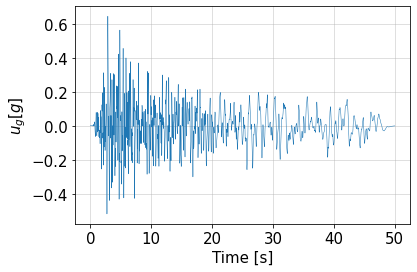

In [4]:
_ = plt.plot(gm['time'], gm['acc']*sf, linewidth=0.5)
_ = plt.grid(which='both', alpha=0.5)
_ = plt.xlabel('Time [s]')
_ = plt.ylabel('$u_g [g]$')

#### COLLECT RESULTS FROM NLRHA

In [5]:
story_response = {}
pz_response = {}
column_response = {}
frac_simulated = {}
FI_simulated = {}
beam_plas_rot = {}
beam_moment = {}

result_list = [os.path.join(results_main_folder, gm_name)]

for model_i, results_folder in enumerate(result_list):
    
    print(results_folder)
    
    story_response[results_folder]  = get_story_response(results_folder, beam_list, ['drift_env','drift'])
#     pz_response[results_folder]     = get_pz_response(results_folder, beam_list, column_list, ['pz_rot'])
#     column_response[results_folder] = get_column_response(results_folder, beam_list, column_list, ['hinge_bot','hinge_top'])
#     frac_simulated[results_folder]  = get_beam_response(results_folder, beam_list, ['frac_LB','frac_LT','frac_RB','frac_RT'])
#     FI_simulated[results_folder]    = get_beam_response(results_folder, beam_list, ['FI_LB','FI_LT','FI_RB','FI_RT'])
#     beam_plas_rot[results_folder]   = get_beam_response(results_folder, beam_list, ['hinge_left','hinge_right'])

    # Compute disp from drift
#     disp = story_response[results_folder]['drift'][0]*story_heights[0]
#     disp_prev = disp
#     for i in range(len(story_heights)-1):
#         ddisp = story_response[results_folder]['drift'][i+1]*story_heights[i+1]
#         disp = np.vstack((disp, disp_prev + ddisp))
#         disp_prev = disp_prev + ddisp
#     story_response[results_folder]['disp'] = disp
        
    # Collect response at a given time #
    ### Time (index) to collect response ###
#     res_type = 'at_t'
#     t = -1
    res_type='all_t'

    pz_response[results_folder]     = get_pz_response(results_folder, beam_list, column_list, ['all_disp', 'pz_rot'], res_type='all_t')
    
    if cvn != 'ASCE41':
    #     beam_plas_rot   = get_beam_response(results_folder, beam_list, ['hinge_left','hinge_right'])
        column_response[results_folder] = get_column_response(results_folder, beam_list, column_list, ['hinge_bot','hinge_top'], res_type)
        beam_plas_rot[results_folder]   = get_beam_response(results_folder, beam_list, ['hinge_left','hinge_right'], res_type)
        beam_moment[results_folder]     = get_beam_response(results_folder, beam_list, ['hinge_left_force', 'hinge_right_force'], res_type)
        frac_simulated[results_folder]  = get_beam_response(results_folder, beam_list, ['frac_LB','frac_LT','frac_RB','frac_RT'], res_type)
        FI_simulated[results_folder]    = get_beam_response(results_folder, beam_list, ['FI_LB','FI_LT','FI_RB','FI_RT'], res_type)
    #         fiber_plas_rot   = get_beam_response(results_folder, beam_list, ['def_left','def_right'])
    else:
        beam_plas_rot[results_folder]   = get_beam_response(results_folder, beam_list, ['hinge_left','hinge_right'], res_type)
        beam_moment[results_folder]     = get_beam_response(results_folder, beam_list, ['hinge_left_force', 'hinge_right_force'], res_type)
        column_response[results_folder] = get_column_response(results_folder, beam_list, column_list, ['hinge_bot','hinge_top'], res_type)
        
print('No. time steps: = ', str(len(pz_response[results_folder]['pz_rot'][0,0,:])))
     

NLRHA_FiberCVN16ftlb\RSN9_BORREGO_B-ELC000.AT2


OSError: NLRHA_FiberCVN16ftlb\RSN9_BORREGO_B-ELC000.AT2/all_disp.out not found.

#### PLOT COLLAPSE MECHANISM

In [ ]:
marker_size = 100 # size marker for fractures

# fig, ax_list = plt.subplots(2,int(len(cvn_list)/2), figsize=(8,8))  
fig, ax_list = plt.subplots(3,len(result_list), figsize=(14,12), gridspec_kw={'height_ratios': [3, 1, 1]})

# element coordinates
plot_scale = 7
n_stories, n_bays, columns, beams, joints_x, joints_y = get_coordinates(beam_list, column_list, bay_widths, story_heights)
edp = np.zeros([n_stories, 1])
t = 3000 #550

# Buildings per simulation
for model_i, results_folder in enumerate(result_list):
    # locate subplot
#     if model_i <= 1:
#         ax = ax_list[0, model_i]
#     else:
#         ax = ax_list[1, model_i-2]
    ax = ax_list[0]#, model_i]
    
    # results folder name
    edp = pz_response[results_folder]['all_disp'] #story_response[results_folder]['disp']
    
    # Adjust EDP if there are beams extending two bays
    if edp.ndim == 3:
        edp = edp[:, :, t]
        
    n_floors, n_piers = edp.shape
    n_stories = n_floors - 1
    n_bays = n_piers - 1
    for i_story in range(n_stories):
        for i_bay in range(n_bays):
            if (beam_list[i_story, min(i_bay + 1, n_bays - 1)] == 0) and \
                    (column_list[i_story, min(i_bay + 1, n_bays)] == 0) and \
                    (column_list[min(i_story + 1, n_stories - 1), min(i_bay + 1, n_bays)] == 0):
                # for double bay beams
#                 print(edp[i_story+1, i_bay + 2])
                edp[i_story+1, min(i_bay + 1, n_bays)] = edp[i_story+1, i_bay+2] 
    
    print(results_folder)
    plot_building_at_t(t, edp, columns, beams, plot_scale, column_list, beam_list, ax, x_gap=500)    
    
    # Plot building response shape
    if cvn == 'ASCE41':
        plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(beam_plas_rot[results_folder]['hinge_left']), 
                                    np.abs(beam_plas_rot[results_folder]['hinge_right']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0015, 0.002, 0.016]), edgecolor=color_specs[model_i], 
                                facecolors=color_specs[model_i], addLegend=True)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(column_response[results_folder]['hinge_bot']), 
                                np.abs(column_response[results_folder]['hinge_top']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.01]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.zeros(column_list.shape), 
                                      np.max(np.abs(pz_response[results_folder]['pz_rot']),axis=2), d_y=0, max_value=1, 
                              max_marker_size=marker_size, plot_scale=plot_scale, 
                              labelText='$\\theta_p$', bins=np.array([0, 0.003, 0.01, 0.02]), addLegend=False)
    else:
    #         plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, FI_simulated['FI_LB'], FI_simulated['FI_RB'], 
    #                                     plot_scale=plot_scale, max_marker_size=marker_size)
        plot_fractures_edp(ax, t, edp, joints_x, joints_y, frac_simulated[results_folder], plot_scale=plot_scale, marker_size=marker_size,
                          one_fracture_color=color_specs[model_i], both_fractures_color='k')
        plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(beam_plas_rot[results_folder]['hinge_left']), 
                                    np.abs(beam_plas_rot[results_folder]['hinge_right']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.02]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(column_response[results_folder]['hinge_bot']), 
                                np.abs(column_response[results_folder]['hinge_top']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.02]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.zeros(column_list.shape), 
                                      np.max(np.abs(pz_response[results_folder]['pz_rot']),axis=2), d_y=0, max_value=1, 
                              max_marker_size=marker_size, plot_scale=plot_scale, 
                              labelText='$\\theta_p$', bins=np.array([0, 0.003, 0.01, 0.02]), addLegend=False)

    # Plot ground motion
    time_response = pz_response[results_folder]['time']
    t_to_plot = time_response[t]
    if t_to_plot > gm['time'][-1]:
        t_to_plot_idx = -1
    else:
        t_to_plot_idx = int(np.argwhere(gm['time'] > t_to_plot)[0][0]) # index to plot
    
    ax = ax_list[1]#, model_i]    
    
    if 'pol2' in results_folder:
        _ = ax.plot(gm['time'], -gm['acc'], color='lightgrey', linewidth=0.5)
        _ = ax.plot(gm['time'][1:t_to_plot_idx], -gm['acc'][1:t_to_plot_idx], color=color_specs[model_i], linewidth=0.5)    
        _ = ax.plot(gm['time'][t_to_plot_idx], -gm['acc'][t_to_plot_idx], 
                    color=color_specs[model_i], marker='o')
    else:
        _ = ax.plot(gm['time'], gm['acc'], color='lightgrey', linewidth=0.5)
        _ = ax.plot(gm['time'][1:t_to_plot_idx], gm['acc'][1:t_to_plot_idx], color=color_specs[model_i], linewidth=0.5)    
        _ = ax.plot(gm['time'][t_to_plot_idx], gm['acc'][t_to_plot_idx], 
                    color=color_specs[model_i], marker='o')
        
#     _ = ax.grid(which='both', alpha=0.5)
    _ = ax.yaxis.set_ticks([])
    _ = ax.set_xlim([0, time_response[-1]])
    _ = ax.set_xlabel('Time [s]')
    _ = ax.set_ylabel('$u_g [g]$')
    
    
    # Plot drift demand
    time_response = pz_response[results_folder]['time']
    t_to_plot = time_response[t]
    if t_to_plot >= time_response[-1]:
        t_to_plot_idx = -1
    else:
        t_to_plot_idx = int(np.argwhere(time_response > t_to_plot)[0][0]) # index to plot
    
    ax = ax_list[2]#, model_i]    
    
    _ = ax.plot(time_response, story_response[results_folder]['drift'][0,:]*100, color='lightgrey', linewidth=1)
    _ = ax.plot(time_response, story_response[results_folder]['drift'][1,:]*100, color='lightgrey', linewidth=1)
    _ = ax.plot(time_response, story_response[results_folder]['drift'][2,:]*100, color='lightgrey', linewidth=1)
    
    _ = ax.plot(time_response[0:t_to_plot_idx], story_response[results_folder]['drift'][0,0:t_to_plot_idx]*100, color='r', linewidth=1)
    _ = ax.plot(time_response[0:t_to_plot_idx], story_response[results_folder]['drift'][1,0:t_to_plot_idx]*100, color='b', linewidth=1)
    _ = ax.plot(time_response[0:t_to_plot_idx], story_response[results_folder]['drift'][2,0:t_to_plot_idx]*100, color='g', linewidth=1)

    _ = ax.plot(time_response[t_to_plot_idx], story_response[results_folder]['drift'][0,t_to_plot_idx]*100, color='r', marker='o')
    _ = ax.plot(time_response[t_to_plot_idx], story_response[results_folder]['drift'][1,t_to_plot_idx]*100, color='b', marker='o')
    _ = ax.plot(time_response[t_to_plot_idx], story_response[results_folder]['drift'][2,t_to_plot_idx]*100, color='g', marker='o')
    
    _ = ax.grid(which='both', alpha=0.5)
    _ = ax.set_ylim([-6, 6])
    _ = ax.set_xlim([0, time_response[-1]])
    _ = ax.set_xlabel('Time [s]')
    _ = ax.set_ylabel('Drift [%]')

plt.tight_layout()



#### END STATE

In [ ]:
marker_size = 100 # size marker for fractures

# fig, ax_list = plt.subplots(2,int(len(cvn_list)/2), figsize=(8,8))  
fig, ax = plt.subplots(1, 1, figsize=(8,8))

# element coordinates
plot_scale = 7
n_stories, n_bays, columns, beams, joints_x, joints_y = get_coordinates(beam_list, column_list, bay_widths, story_heights)
edp = np.zeros([n_stories, 1])
t = -1

# Buildings per simulation
for model_i, results_folder in enumerate(result_list):
    
    # results folder name
    edp = pz_response[results_folder]['all_disp'] #story_response[results_folder]['disp']
    
    # Adjust EDP if there are beams extending two bays
    if edp.ndim == 3:
        edp = edp[:, :, t]
        
    n_floors, n_piers = edp.shape
    n_stories = n_floors - 1
    n_bays = n_piers - 1
    for i_story in range(n_stories):
        for i_bay in range(n_bays):
            if (beam_list[i_story, min(i_bay + 1, n_bays - 1)] == 0) and \
                    (column_list[i_story, min(i_bay + 1, n_bays)] == 0) and \
                    (column_list[min(i_story + 1, n_stories - 1), min(i_bay + 1, n_bays)] == 0):
                # for double bay beams
#                 print(edp[i_story+1, i_bay + 2])
                edp[i_story+1, min(i_bay + 1, n_bays)] = edp[i_story+1, i_bay+2] 
    
    print(results_folder)
    plot_building_at_t(t, edp, columns, beams, plot_scale, column_list, beam_list, ax, x_gap=500)    
    
    # Plot building response shape
    if cvn == 'ASCE41':
        plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, np.max(np.abs(beam_plas_rot[results_folder]['hinge_left']), axis=2), 
                                    np.max(np.abs(beam_plas_rot[results_folder]['hinge_right']), axis=2), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0015, 0.002, 0.016]), edgecolor=color_specs[model_i], 
                                facecolors=color_specs[model_i], addLegend=True)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.max(np.abs(column_response[results_folder]['hinge_bot']), axis=2), 
                                np.max(np.abs(column_response[results_folder]['hinge_top']), axis=2), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.01]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.zeros(column_list.shape), 
                                      np.max(np.abs(pz_response[results_folder]['pz_rot']),axis=2), d_y=0, max_value=1, 
                              max_marker_size=marker_size, plot_scale=plot_scale, 
                              labelText='$\\theta_p$', bins=np.array([0, 0.003, 0.01, 0.02]), addLegend=False)
    else:
    #         plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, FI_simulated['FI_LB'], FI_simulated['FI_RB'], 
    #                                     plot_scale=plot_scale, max_marker_size=marker_size)
        plot_fractures_edp(ax, t, edp, joints_x, joints_y, frac_simulated[results_folder], plot_scale=plot_scale, marker_size=marker_size,
                          one_fracture_color=color_specs[model_i], both_fractures_color='k')
        plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, np.max(np.abs(beam_plas_rot[results_folder]['hinge_left']),axis=2), 
                                    np.max(np.abs(beam_plas_rot[results_folder]['hinge_right']),axis=2), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.02]), edgecolor='grey', 
                                facecolors='grey', addLegend=True)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.max(np.abs(column_response[results_folder]['hinge_bot']),axis=2), 
                                np.max(np.abs(column_response[results_folder]['hinge_top']),axis=2), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.02]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.zeros(column_list.shape), 
                                      np.max(np.abs(pz_response[results_folder]['pz_rot']),axis=2), d_y=0, max_value=1, 
                              max_marker_size=marker_size, plot_scale=plot_scale, 
                              labelText='$\\theta_p$', bins=np.array([0, 0.003, 0.01, 0.02]), addLegend=False)

        _ = ax.set_title('Maximum demands')
        
plt.tight_layout()



#### ENVELOPE DRIFT PROFILE

In [ ]:
x_ticks = np.array([0, 2.0, 4.0, 6.0, 8.0, 10.0])

# Peak drift profile
fig, ax = plt.subplots(1,1, figsize=(6,8)) 

legend_text = []
for model_i, results_folder in enumerate(result_list):
    
    print('total time = ' + str(pz_response[results_folder]['time'][-1]) + 's')
    
    plot_story_response(ax, story_response[results_folder]['drift_env'], story_heights, bay_widths, 
                        color_name=color_specs[model_i], x_ticks=x_ticks)

    legend_text.append(results_folder)
    
# _ = ax.legend(legend_text)#,bbox_to_anchor=(1.05, 1), loc='best')

### PEAK ROTATION DEMANDS

In [ ]:
print('PANEL ZONE ROTATION')
np.max(np.abs(pz_response[results_folder]['pz_rot']),axis=2)

print('\nBOTTOM HINGE ROTATION')
np.max(np.abs(column_response[results_folder]['hinge_bot']), axis=2)
print('\nTOP HINGE ROTATION')
np.max(np.abs(column_response[results_folder]['hinge_top']), axis=2)

print('\nLEFT HINGE ROTATION')
np.max(np.abs(beam_plas_rot[results_folder]['hinge_left']), axis=2)
print('\nRIGHT HINGE ROTATION')
np.max(np.abs(beam_plas_rot[results_folder]['hinge_right']), axis=2)

In [ ]:
_ = plt.plot(time_response, column_response[results_folder]['hinge_top'][0,0,:])
_ = plt.grid(which='both', alpha=0.5)
_ = plt.ylim([-6/100, 6/100])
_ = plt.xlim([0, time_response[-1]])
_ = plt.xlabel('Time [s]')
_ = plt.ylabel('Rotation [rad]')

In [ ]:
_ = plt.plot(time_response, column_response[results_folder]['hinge_top'][0,0,:])
_ = plt.grid(which='both', alpha=0.5)
_ = plt.ylim([-6/100, 6/100])
# _ = plt.xlim([0, time_response[-1]])
_ = plt.xlabel('Time [s]')
_ = plt.ylabel('Rotation [rad]')

In [ ]:
_ = plt.plot(time_response, beam_plas_rot[results_folder]['hinge_left'][0].flatten())
_ = plt.grid(which='both', alpha=0.5)
_ = plt.ylim([-6/100, 6/100])
_ = plt.xlim([0, time_response[-1]])
_ = plt.xlabel('Time [s]')
_ = plt.ylabel('Rotation [rad]')

In [ ]:
_ = plt.plot(beam_plas_rot[results_folder]['hinge_left'][0].flatten(), 
             beam_moment[results_folder]['hinge_left_force'][0].flatten(), '-o')
_ = plt.grid(which='both', alpha=0.5)
_ = plt.ylabel('Moment [kip-in]')
_ = plt.xlabel('Rotation [rad]')